In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, neighbors, ensemble, svm, metrics
from imblearn.under_sampling import CondensedNearestNeighbour 

### Составляем различные таблицы

In [2]:
dau = pd.read_csv('practice_dau_and.csv', sep='|')
pact = pd.read_csv('practice_pact_and.csv', sep='|')
print('Loaded')

Loaded


In [17]:
pay_players = pact[pact.transactions > 0].reset_index()
pay_players = pay_players.drop(['index'], axis='columns')
#print(pay_players)
pay_players.to_csv('pay_players_pact.csv', sep='|')
pay_players = pay_players.groupby(['id'], as_index=False).count()
pay_players = pay_players.drop(['actdate', 'regdate', 'clusters', 
                                'revenue', 'transactions', 'quest',
                                'm_quests', 'crystals', 'store_enters'], axis='columns')
print(pay_players)
pay_players.to_csv('pay_players.csv')

               id
0      0001c0d9c5
1      000249ee3b
2      0004bbc378
3      000bc5be57
4      00137c70eb
5      001501221a
6      001566c949
7      0016ec0270
8      001bdcf118
9      001dcb349d
10     001e86bb74
11     001f6f6bda
12     00217a789a
13     00240222ee
14     002adc591b
15     002d410bd3
16     002f2521f5
17     0030797a91
18     0030b81513
19     0032eb2d55
20     00332e58de
21     003544c4ea
22     003717dd8c
23     00371a21a9
24     00380b3464
25     003b4acbbd
26     003c981696
27     003d74cb8d
28     003e1afdab
29     003e67dd8a
...           ...
30391  ffb16a1c26
30392  ffb3c42867
30393  ffb5376eee
30394  ffb71a2641
30395  ffbbd7823a
30396  ffbd959b77
30397  ffbff6e3b0
30398  ffc1670161
30399  ffc286fc79
30400  ffc638b435
30401  ffc7cc6362
30402  ffca076aee
30403  ffd59fa03d
30404  ffd5a29fa9
30405  ffdc226141
30406  ffdd5e88b8
30407  ffdf621be9
30408  ffe0ac456f
30409  ffe5094796
30410  ffe5227876
30411  ffe8349510
30412  ffea788845
30413  ffeba687e9
30414  ffe

In [20]:
dau2 = pd.merge(pay_players, dau, on=['id'], how='left')

In [103]:
print(dau)
print(dau2)

In [22]:
dau2.to_csv('pay_players_dau.csv')

In [24]:
dau_pact = pd.merge(dau2, pact, on=['id', 'actdate'], how='left')

In [26]:
print(dau_pact)
dau_pact.to_csv('pay_players_dau_pact.csv')

                id country  pgr     actdate     regdate  clusters  revenue  \
0       0001c0d9c5      RU    7  2017-01-28         NaN       NaN      NaN   
1       0001c0d9c5      RU   23  2017-01-30  2017-01-24      19.0     0.00   
2       0001c0d9c5      RU  219  2017-01-24  2017-01-24      13.0  4237.98   
3       0001c0d9c5      RU  164  2017-01-26  2017-01-24      18.0     0.00   
4       0001c0d9c5      RU  169  2017-01-25  2017-01-24      17.0  5922.96   
5       0001c0d9c5      RU   68  2017-01-29  2017-01-24      19.0  2118.99   
6       0001c0d9c5      RU    6  2017-03-01  2017-03-01      -2.0     0.00   
7       000249ee3b      US    2  2017-04-17         NaN       NaN      NaN   
8       000249ee3b      US   84  2017-04-13  2017-04-11       8.0     0.00   
9       000249ee3b      US   67  2017-04-16  2017-04-11       9.0     0.00   
10      000249ee3b      US  227  2017-04-11  2017-04-11       5.0     0.00   
11      000249ee3b      US   96  2017-04-12  2017-04-11       5.

In [65]:
dau2 = pd.read_csv('pay_players_dau.csv', parse_dates=True).drop('Unnamed: 0', axis='columns')

In [27]:
dau_pact = dau_pact.set_index('actdate', drop=False).sort_index(0)

### График, показывающий активность игрока

In [19]:
def show_player_pgr(player_id, days=31):
    player_table = pd.DataFrame({'id': [player_id]})
    res = pd.merge(player_table, dau_pact, on=['id'], how='left')
    #print(res)
    res = res.drop(['crystals', 'store_enters', 'm_quests', 'quest', 
                    'revenue', 'transactions', 'country', 'clusters'], axis='columns')
    res = res.groupby(['actdate'], as_index=False).sum()
    res = res.set_index('actdate')
    res = res.sort_index(0)
    res = res.reset_index()
    #print(res)
    first_day = res['actdate'][0]
    m_later_day = pd.date_range(first_day, periods=days, freq='D').date[-1]
    #print(first_day, str(m_later_day))
    new_sample_df = res.set_index('actdate').loc[first_day:str(m_later_day)]
    new_sample_df.plot()
    plt.show()

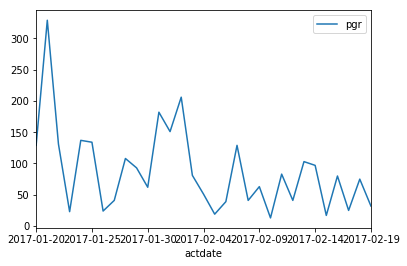

In [20]:
show_player_pgr('0004bbc378')

### Сводная таблица

In [42]:
dau_pact = pd.read_csv('pay_players_dau_pact.csv').drop('Unnamed: 0', axis='columns')
dau_pact_table = dau_pact.drop(['clusters', 'revenue', 'quest', 
                          'm_quests', 'crystals', 'store_enters', 
                          'transactions', 'country'], axis='columns')

In [43]:
dau_pact_table['day_n'] = (pd.to_datetime(dau_pact_table['actdate']) - 
                           pd.to_datetime(dau_pact_table['regdate'])).dt.days
dau_pact_table = dau_pact_table[dau_pact_table.day_n < 31 + 14].reset_index()
dau_pact_table = dau_pact_table[pd.to_datetime(dau_pact_table.regdate) < pd.to_datetime('2017-04-15')].reset_index()
dau_pact_table = dau_pact_table.pivot_table(values='pgr', columns=['day_n'], index=['id'], aggfunc='sum')

In [67]:
print(dau_pact_table)

               0.0     1.0     2.0     3.0     4.0     5.0     6.0     7.0  \
id                                                                           
0001c0d9c5   225.0   169.0   164.0     NaN     NaN    68.0    23.0     NaN   
000249ee3b   227.0    96.0   142.0     NaN     NaN    67.0     NaN     NaN   
0004bbc378   129.0   329.0   131.0     NaN   137.0   134.0    24.0    41.0   
000bc5be57   413.0    81.0   233.0   123.0    92.0    45.0    79.0     NaN   
00137c70eb   550.0    70.0     NaN   180.0     NaN   286.0   230.0   191.0   
001566c949   229.0    42.0   124.0     NaN     NaN     NaN    98.0   230.0   
0016ec0270   416.0   221.0     NaN    93.0    19.0     NaN    45.0   165.0   
001bdcf118   260.0    15.0     NaN     NaN    47.0   162.0   147.0     NaN   
001dcb349d   180.0   339.0    91.0    64.0     NaN    96.0    51.0     NaN   
001e86bb74    55.0    59.0    34.0    73.0    56.0     NaN   142.0    55.0   
001f6f6bda   173.0   478.0    25.0    15.0     NaN   148.0    86

In [5]:
dau_pact_table.to_csv('dau_pact_table.csv')

### Различные признаки

In [21]:
dau_pact_table['m_played'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9, 
                      10, 11, 12, 13, 14, 15, 16,
                      17, 18, 19, 20, 21, 22, 23, 
                      24, 25, 26, 27, 28, 29, 30]].count(1)
dau_pact_table['w1_played'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9]].count(1)
dau_pact_table['w2_played'] = dau_pact_table[[10.0, 11, 12, 13, 14, 15, 16]].count(1)
dau_pact_table['w3_played'] = dau_pact_table[[17.0, 18, 19, 20, 21, 22, 23]].count(1)
dau_pact_table['w4_played'] = dau_pact_table[[24.0, 25, 26, 27, 28, 29, 30]].count(1)
dau_pact_table['w1_max'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).max(1)
dau_pact_table['w2_max'] = dau_pact_table[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).max(1)
dau_pact_table['w3_max'] = dau_pact_table[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).max(1)
dau_pact_table['w4_max'] = dau_pact_table[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).max(1)
dau_pact_table['w1_mean'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).mean(1)
dau_pact_table['w2_mean'] = dau_pact_table[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).mean(1)
dau_pact_table['w3_mean'] = dau_pact_table[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).mean(1)
dau_pact_table['w4_mean'] = dau_pact_table[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).mean(1)
dau_pact_table['w1_meandmax'] = (dau_pact_table['w1_mean'] / dau_pact_table['w1_max']).replace('NaN', 0)
dau_pact_table['w2_meandmax'] = (dau_pact_table['w2_mean'] / dau_pact_table['w2_max']).replace('NaN', 0)
dau_pact_table['w3_meandmax'] = (dau_pact_table['w3_mean'] / dau_pact_table['w3_max']).replace('NaN', 0)
dau_pact_table['w4_meandmax'] = (dau_pact_table['w4_mean'] / dau_pact_table['w4_max']).replace('NaN', 0)
dau_pact_table['result_played'] = dau_pact_table[[31.0, 32, 33, 34, 35, 36, 37,
                                                  38, 39, 40, 41, 42, 43, 44]].count(1)
dau_pact_table['is_active'] = (dau_pact_table['result_played'] > 1) * 1
dau_pact_table['result_category'] = (dau_pact_table['result_played'] / 4).round()
#dau_pact_table['result_intensity'] = dau_pact_table[[31.0, 32, 33, 34, 35, 36, 37,
#                                                  38, 39, 40, 41, 42, 43, 44]].replace('NaN', 0).mean(1)
print(dau_pact_table)

               id     0.0     1.0     2.0     3.0     4.0     5.0     6.0  \
0      0001c0d9c5   225.0   169.0   164.0     NaN     NaN    68.0    23.0   
1      000249ee3b   227.0    96.0   142.0     NaN     NaN    67.0     NaN   
2      0004bbc378   129.0   329.0   131.0     NaN   137.0   134.0    24.0   
3      000bc5be57   413.0    81.0   233.0   123.0    92.0    45.0    79.0   
4      00137c70eb   550.0    70.0     NaN   180.0     NaN   286.0   230.0   
5      001566c949   229.0    42.0   124.0     NaN     NaN     NaN    98.0   
6      0016ec0270   416.0   221.0     NaN    93.0    19.0     NaN    45.0   
7      001bdcf118   260.0    15.0     NaN     NaN    47.0   162.0   147.0   
8      001dcb349d   180.0   339.0    91.0    64.0     NaN    96.0    51.0   
9      001e86bb74    55.0    59.0    34.0    73.0    56.0     NaN   142.0   
10     001f6f6bda   173.0   478.0    25.0    15.0     NaN   148.0    86.0   
11     00217a789a   123.0     7.0    56.0     NaN     8.0     NaN     NaN   

### Регрессия:

In [62]:
#clf_features = ['w1_played', 'w2_played', 'w3_played', 'w4_played',
#                 'w1_meandmax', 'w2_meandmax', 'w3_meandmax', 'w4_meandmax',
#                 'w1_mean', 'w2_mean', 'w3_mean', 'w4_mean',
#                 'clusters_w1_mean', 'clusters_w2_mean', 'clusters_w3_mean', 'clusters_w4_mean']#,
#                'quest_w1_mean',
#              'quest_w2_mean',        'quest_w3_mean',        'quest_w4_mean',
#           'm_quests_w1_mean',     'm_quests_w2_mean',     'm_quests_w3_mean',
#           'm_quests_w4_mean',     'crystals_w1_mean',     'crystals_w2_mean',
#           'crystals_w3_mean',     'crystals_w4_mean', 'transactions_w1_mean',
#       'transactions_w2_mean', 'transactions_w3_mean', 'transactions_w4_mean']

dau_pact_table.replace('NaN', 0, inplace=True)

train_input_clf = dau_pact_table[:16000].as_matrix(columns=clf_features)
train_output_clf = np.array(dau_pact_table['is_active'][:16000].tolist())

#cnn = CondensedNearestNeighbour(random_state=42) 
#train_input_clf, train_output_clf = cnn.fit_sample(train_input_clf, train_output_clf)

#fitted_clf = linear_model.SGDClassifier(loss='log', epsilon=0.01, n_iter=4).fit(train_input_clf, train_output_clf)
#dau_pact_table['predict_active'] = fitted_clf.predict(dau_pact_table.as_matrix(columns=['w1_played', 'w2_played', 'w3_played', 'w4_played',
#                                                                                        'w1_meandmax', 'w2_meandmax', 'w3_meandmax', 'w4_meandmax'])).round()

#fitted_clf = linear_model.SGDRegressor(epsilon=0.01).fit(train_input_clf, train_output_clf)
#dau_pact_table['predict_active'] = fitted_clf.predict(dau_pact_table.as_matrix(columns=clf_features)).round()

#fitted_clf_rfr = ensemble.RandomForestRegressor(n_estimators=30).fit(train_input_clf, train_output_clf)
#dau_pact_table['predict_active'] = fitted_clf_rfr.predict(dau_pact_table.as_matrix(columns=['w1_played', 'w2_played', 'w3_played', 'w4_played',
#                                                                                        'w1_meandmax', 'w2_meandmax', 'w3_meandmax', 'w4_meandmax'])).round()


fitted_clf_gbr = ensemble.GradientBoostingRegressor(subsample=0.7, loss='ls').fit(train_input_clf, train_output_clf)
dau_pact_table['predict_active'] = fitted_clf_gbr.predict(dau_pact_table.as_matrix(
                                                            columns=clf_features)).round()

#fitted_clf_etr = ensemble.ExtraTreesRegressor(n_estimators=20).fit(train_input_clf, train_output_clf)
#dau_pact_table['predict_active'] = fitted_clf_etr.predict(dau_pact_table.as_matrix(columns=['w1_played', 'w2_played', 'w3_played', 'w4_played',
#                                                                                        'w1_meandmax', 'w2_meandmax', 'w3_meandmax', 'w4_meandmax'])).round()

#fitted_clf_svc = svm.SVC().fit(train_input_clf, train_output_clf)
#dau_pact_table['predict_active'] = fitted_clf_svc.predict(dau_pact_table.as_matrix(columns=['w1_played', 'w2_played', 'w3_played', 'w4_played',
#                                                                                        'w1_meandmax', 'w2_meandmax', 'w3_meandmax', 'w4_meandmax'])).round()


#fitted_clf_knr = neighbors.KNeighborsRegressor().fit(train_input_clf, train_output_clf)
#dau_pact_table['predict_active'] = fitted_clf_knr.predict(dau_pact_table.as_matrix(columns=['w1_played', 'w2_played', 'w3_played', 'w4_played',
#                                                                                            'w1_meandmax', 'w2_meandmax', 'w3_meandmax', 'w4_meandmax'])).round()

train_input_prd = dau_pact_table[:16000][dau_pact_table['is_active'] == 1].as_matrix(columns=clf_features)
train_output_prd = np.array(dau_pact_table[:16000][dau_pact_table['is_active'] == 1]['result_played'].tolist())

#train_input_prd, train_output_prd = cnn.fit_sample(train_input_prd, train_output_prd)
#fitted_prd = linear_model.SGDRegressor(epsilon=0.01).fit(train_input_prd, train_output_prd)
#dau_pact_table['predict_days'] = fitted_prd.predict(dau_pact_table.as_matrix(columns=['w1_played', 'w2_played', 'w3_played', 'w4_played',
#                                                                                      'w1_meandmax', 'w2_meandmax', 'w3_meandmax', 'w4_meandmax'])) * dau_pact_table['predict_active']

#fitted_prd_rfr = ensemble.RandomForestRegressor().fit(train_input_prd, train_output_prd)
#dau_pact_table['predict_days'] = fitted_prd_rfr.predict(dau_pact_table.as_matrix(columns=['w1_played', 'w2_played', 'w3_played', 'w4_played',
#                                                                                      'w1_meandmax', 'w2_meandmax', 'w3_meandmax', 'w4_meandmax'])) * dau_pact_table['predict_active']

fitted_prd_etr = ensemble.ExtraTreesRegressor(n_estimators=100).fit(train_input_prd, train_output_prd)
dau_pact_table['predict_days'] = fitted_prd_etr.predict(dau_pact_table.as_matrix(columns=clf_features))

#fitted_prd_bgr = ensemble.GradientBoostingRegressor(subsample=0.6, loss='ls').fit(train_input_prd, train_output_prd)
#dau_pact_table['predict_days'] = fitted_prd_bgr.predict(dau_pact_table.as_matrix(columns=['w1_played', 'w2_played', 'w3_played', 'w4_played',
#                                                                                      'w1_meandmax', 'w2_meandmax', 'w3_meandmax', 'w4_meandmax'])) * dau_pact_table['predict_active']

#fitted_prd_knr = neighbors.KNeighborsRegressor(10).fit(train_input_prd, train_output_prd)
#dau_pact_table['predict_days'] = fitted_prd_knr.predict(dau_pact_table.as_matrix(columns=['w1_played', 'w2_played', 'w3_played', 'w4_played',
#                                                                                      'w1_meandmax', 'w2_meandmax', 'w3_meandmax', 'w4_meandmax'])) * dau_pact_table['predict_active']

#train_input_cat = dau_pact_table[:16000].as_matrix(columns=clf_features)
#train_output_cat = np.array(dau_pact_table['result_category'][:16000].tolist())

#fitted_cat_prd_knr = neighbors.KNeighborsRegressor(10).fit(train_input_cat, train_output_cat)
#dau_pact_table['predict_category'] = fitted_cat_prd_knr.predict(dau_pact_table.as_matrix(columns=clf_features)).round()


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:49: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:50: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


### Попытки предсказаний, точность

In [63]:
#dau_pact_table['predict_intensity'] = (dau_pact_table['w1_mean'] * 0.2 
#                                       + dau_pact_table['w2_mean'] * 0.3 
#                                       + dau_pact_table['w3_mean'] * 0.5
#                                       + dau_pact_table['w4_mean'] * 1)
#dau_pact_table['intensity_acc'] = ((dau_pact_table['result_intensity'] - dau_pact_table['predict_intensity']).abs()
#                                   / (dau_pact_table['result_intensity']))
#dau_pact_table['predict_played'] = (dau_pact_table['w1_played'] * 0.2
#                                    + dau_pact_table['w2_played'] * 0.3
#                                    + dau_pact_table['w3_played'] * 0.5
#                                    + dau_pact_table['w4_played'] * 1).round()
#dau_pact_table['played_acc'] = ((dau_pact_table['result_played'] - dau_pact_table['predict_played']).abs()
#                                / (dau_pact_table['result_played']))
dau_pact_table['clf_acc'] = (dau_pact_table['is_active'] == dau_pact_table['predict_active']) * 1
dau_pact_table['clf_e1'] = (dau_pact_table['is_active'] > dau_pact_table['predict_active']) * 1
dau_pact_table['clf_e2'] = (dau_pact_table['is_active'] < dau_pact_table['predict_active']) * 1
#dau_pact_table['prd_acc'] = ((dau_pact_table['result_played'] - dau_pact_table['predict_days']).abs()
#                                / (dau_pact_table['result_played']))
dau_pact_table['prd_delta'] = ((dau_pact_table['result_played'] - dau_pact_table['predict_days']).abs())
dau_pact_table['overall_delta'] = ((dau_pact_table['result_played'] * dau_pact_table['is_active'] - dau_pact_table['predict_days'] * dau_pact_table['predict_active']).abs())
#dau_pact_table['category_delta'] = ((dau_pact_table['result_category'] - dau_pact_table['predict_category'])).abs()
#print(dau_pact_table)
#dau_pact_table = dau_pact_table.set_index('id')

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Среднее отклонение классификатора активности: 0.101197891711
Ошибка классификатора 1 рода (игрок на самом деле активен): 0.0707235265932
Ошибка классификатора 2 рода (игрок на самом деле неактивен): 0.0304743651174
Среднее отклонение предсказателя дней: 2.65885126472
Среднее общее отклонение: 1.09539474122
[9089, 1598, 497, 96]
[2308, 1380, 338, 69]


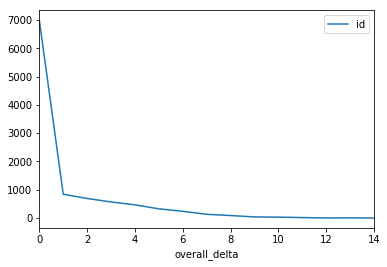

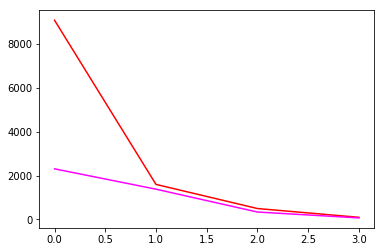

In [64]:
#num_inf = 0
#sum_infs = 0
#sum_v = 0
#num_v = 0
#nans = 0
prd_delta = dau_pact_table[16000:][dau_pact_table['is_active'] == 1]['prd_delta'].mean()
clf_delta = 1 - dau_pact_table['clf_acc'][16000:].mean()
clf_e1 = dau_pact_table['clf_e1'][16000:].mean()
clf_e2 = dau_pact_table['clf_e2'][16000:].mean()
overall_delta = dau_pact_table['overall_delta'][16000:].mean()
#category_delta = dau_pact_table['category_delta'][16000:].mean()
#for i in range(0, 26435):
#    #print(dau_pact_table['played_acc'][i])
#    if np.isnan(dau_pact_table['regr_acc'][i]):
#        nans += 1
#    elif not np.isfinite(dau_pact_table['regr_acc'][i]):
#        sum_infs += dau_pact_table['regr_predict_played'][i]
#        num_inf += 1
#    else:
#        sum_v += dau_pact_table['regr_acc'][i]
#        num_v += 1
#print("Среднее процентное отклонение (не inf):", sum_v / num_v * 100, '%')
#print("Среднее отклонение для acc=inf (дни): ", sum_infs / num_inf)
#print("Среднее отклонение (дни):", delta)
print('Среднее отклонение классификатора активности:', clf_delta)
print('Ошибка классификатора 1 рода (игрок на самом деле активен):', clf_e1)
print('Ошибка классификатора 2 рода (игрок на самом деле неактивен):', clf_e2)
print('Среднее отклонение предсказателя дней:', prd_delta)
print('Среднее общее отклонение:', overall_delta)
#print('Среднее отклонение категории:', category_delta)
overall_delta_round = dau_pact_table['overall_delta'][16000:].round().reset_index().pivot_table(values=['id'], index=['overall_delta'], aggfunc='count')
active_delta_round = dau_pact_table[16000:][dau_pact_table['is_active'] == 1.0]['overall_delta'].round().reset_index().pivot_table(values=['id'], index=['overall_delta'], aggfunc='count')
overall_delta_round.plot()
#print(overall_delta_round)
#print(active_delta_round)
categories_delta = [int(overall_delta_round[0:3].sum()), int(overall_delta_round[3:6].sum()), int(overall_delta_round[6:9].sum()), int(overall_delta_round[9:14].sum())]
active_categories_delta = [int(active_delta_round[0:3].sum()), int(active_delta_round[3:6].sum()), int(active_delta_round[6:9].sum()), int(active_delta_round[9:14].sum())]
print(categories_delta)
print(active_categories_delta)
plt.show()
plt.plot(categories_delta, color='red')
plt.plot(active_categories_delta, color='magenta')
plt.show()

In [65]:
print(fitted_clf_gbr.feature_importances_)
print(fitted_prd_etr.feature_importances_)

[  7.82790804e-03   1.09302939e-02   1.71182657e-02   4.85212562e-03
   1.97905073e-02   1.43959832e-02   7.51316065e-03   6.33078512e-03
   1.16700015e-02   8.88611283e-03   9.07207337e-03   7.30944957e-03
   1.16442975e-02   1.22255893e-02   1.01403866e-02   1.56689306e-02
   1.70176515e-02   1.29230537e-03   1.51271231e-02   2.37344681e-02
   4.95349658e-03   2.06143738e-02   1.79863702e-02   2.03780759e-02
   2.51652438e-02   3.23365960e-02   6.17704395e-02   8.20228368e-02
   1.27830359e-02   1.61016286e-03   5.06803680e-03   4.27980996e-03
   1.76386402e-02   1.63553455e-02   6.72616637e-03   2.57384535e-03
   3.06065079e-03   8.17436479e-03   1.11300810e-02   5.02642771e-03
   2.84928010e-03   1.49315317e-03   9.91733885e-03   0.00000000e+00
   1.38048937e-04   4.23630251e-04   2.04776358e-03   1.43774116e-02
   5.28552707e-03   2.37912232e-05   6.32750696e-04   0.00000000e+00
   5.14405708e-03   2.22880781e-02   5.24776429e-03   7.52676598e-03
   4.18508388e-03   5.45271005e-03

In [44]:
dau_pact_features = pd.read_csv('pay_players_dau_pact.csv').drop('Unnamed: 0', axis='columns')
features = ['pgr', 'clusters', 'quest', 'm_quests', 'revenue', 'transactions']
dau_pact_features['day_n'] = (pd.to_datetime(dau_pact_features['actdate']) - 
                           pd.to_datetime(dau_pact_features['regdate'])).dt.days
dau_pact_features = dau_pact_features[dau_pact_features.day_n < 31 + 14]
dau_pact_features = dau_pact_features[pd.to_datetime(dau_pact_features.regdate) < pd.to_datetime('2017-04-15')]
pay_players = pd.read_csv('pay_players.csv').drop('Unnamed: 0', axis='columns')
feature_table = pd.DataFrame(pay_players)
clf_features = []
#print(feature_table)
for feat in features:
    dau_pact_features_tmp = dau_pact_features.pivot_table(values=feat, columns=['day_n'], index=['id'], aggfunc='sum')
    dau_pact_features_tmp[feat+'_w1_mean'] = dau_pact_features_tmp[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).mean(1)
    dau_pact_features_tmp[feat+'_w2_mean'] = dau_pact_features_tmp[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).mean(1)
    dau_pact_features_tmp[feat+'_w3_mean'] = dau_pact_features_tmp[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).mean(1)
    dau_pact_features_tmp[feat+'_w4_mean'] = dau_pact_features_tmp[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).mean(1)
    for col in dau_pact_features_tmp.columns[:-4]:
        if col >= 3.0 and col <= 30.0:
            clf_features.append(feat+'_'+str(col))
        dau_pact_features_tmp.rename(columns={col: feat+'_'+str(col)}, inplace=True)
    dau_pact_features_tmp = dau_pact_features_tmp.reset_index()
    #print(dau_pact_features_tmp)
    #print(pd.DataFrame({'id': dau_pact_features_tmp['id'],
    #                                                      feat+'_w1_mean': dau_pact_features_tmp[feat+'_w1_mean'],
    #                                                      feat+'_w2_mean': dau_pact_features_tmp[feat+'_w2_mean'],
    #                                                      feat+'_w3_mean': dau_pact_features_tmp[feat+'_w3_mean'],
    #                                                      feat+'_w4_mean': dau_pact_features_tmp[feat+'_w4_mean']}))
    #print(feature_table)
    #feature_table = pd.merge(feature_table, pd.DataFrame({'id': dau_pact_features_tmp['id'],
    #                                                      feat+'_w1_mean': dau_pact_features_tmp[feat+'_w1_mean'],
    #                                                      feat+'_w2_mean': dau_pact_features_tmp[feat+'_w2_mean'],
    #                                                      feat+'_w3_mean': dau_pact_features_tmp[feat+'_w3_mean'],
    #                                                      feat+'_w4_mean': dau_pact_features_tmp[feat+'_w4_mean']}), 
    #                         how='inner', on=['id'])
    feature_table = pd.merge(feature_table, dau_pact_features_tmp, on='id', how='inner')
    #print(feature_table)
    #print(pd.DataFrame([dau_pact_features_tmp['id'],
    #                                                  dau_pact_features_tmp[feat+'_w1_mean'],
    #                                                  dau_pact_features_tmp[feat+'_w2_mean'],
    #                                                  dau_pact_features_tmp[feat+'_w3_mean'],
    #                                                  dau_pact_features_tmp[feat+'_w4_mean']]))
    #dau_pact_features[feat+'_w1_mean'] = dau_pact_features_tmp[feat+'_w1_mean']
    #dau_pact_features[feat+'_w2_mean'] = dau_pact_features_tmp[feat+'_w2_mean']
    #dau_pact_features[feat+'_w3_mean'] = dau_pact_features_tmp[feat+'_w3_mean']
    #dau_pact_features[feat+'_w4_mean'] = dau_pact_features_tmp[feat+'_w4_mean']
    #print(dau_pact_features)

In [6]:
print(feature_table)
print(feature_table.columns)

               id  pgr_0.0  pgr_1.0  pgr_2.0  pgr_3.0  pgr_4.0  pgr_5.0  \
0      0001c0d9c5    225.0    169.0    164.0      NaN      NaN     68.0   
1      000249ee3b    227.0     96.0    142.0      NaN      NaN     67.0   
2      0004bbc378    129.0    329.0    131.0      NaN    137.0    134.0   
3      000bc5be57    413.0     81.0    233.0    123.0     92.0     45.0   
4      00137c70eb    550.0     70.0      NaN    180.0      NaN    286.0   
5      001566c949    229.0     42.0    124.0      NaN      NaN      NaN   
6      0016ec0270    416.0    221.0      NaN     93.0     19.0      NaN   
7      001bdcf118    260.0     15.0      NaN      NaN     47.0    162.0   
8      001dcb349d    180.0    339.0     91.0     64.0      NaN     96.0   
9      001e86bb74     55.0     59.0     34.0     73.0     56.0      NaN   
10     001f6f6bda    173.0    478.0     25.0     15.0      NaN    148.0   
11     00217a789a    123.0      7.0     56.0      NaN      8.0      NaN   
12     002adc591b    109.

In [25]:
feature_table.to_csv('feature_table.csv', index=False)

In [47]:
feature_table = pd.read_csv('feature_table.csv')
dau_pact_table = pd.merge(dau_pact_table.reset_index(), feature_table, on='id', how='inner')

In [53]:
print(dau_pact_table)

               0.0     1.0     2.0     3.0     4.0     5.0     6.0     7.0  \
id                                                                           
0001c0d9c5   225.0   169.0   164.0     NaN     NaN    68.0    23.0     NaN   
000249ee3b   227.0    96.0   142.0     NaN     NaN    67.0     NaN     NaN   
0004bbc378   129.0   329.0   131.0     NaN   137.0   134.0    24.0    41.0   
000bc5be57   413.0    81.0   233.0   123.0    92.0    45.0    79.0     NaN   
00137c70eb   550.0    70.0     NaN   180.0     NaN   286.0   230.0   191.0   
001566c949   229.0    42.0   124.0     NaN     NaN     NaN    98.0   230.0   
0016ec0270   416.0   221.0     NaN    93.0    19.0     NaN    45.0   165.0   
001bdcf118   260.0    15.0     NaN     NaN    47.0   162.0   147.0     NaN   
001dcb349d   180.0   339.0    91.0    64.0     NaN    96.0    51.0     NaN   
001e86bb74    55.0    59.0    34.0    73.0    56.0     NaN   142.0    55.0   
001f6f6bda   173.0   478.0    25.0    15.0     NaN   148.0    86

In [48]:
dau_pact_table['m_played'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9, 
                      10, 11, 12, 13, 14, 15, 16,
                      17, 18, 19, 20, 21, 22, 23, 
                      24, 25, 26, 27, 28, 29, 30]].count(1)
dau_pact_table['w1_played'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9]].count(1)
dau_pact_table['w2_played'] = dau_pact_table[[10.0, 11, 12, 13, 14, 15, 16]].count(1)
dau_pact_table['w3_played'] = dau_pact_table[[17.0, 18, 19, 20, 21, 22, 23]].count(1)
dau_pact_table['w4_played'] = dau_pact_table[[24.0, 25, 26, 27, 28, 29, 30]].count(1)
dau_pact_table['w1_max'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).max(1)
dau_pact_table['w2_max'] = dau_pact_table[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).max(1)
dau_pact_table['w3_max'] = dau_pact_table[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).max(1)
dau_pact_table['w4_max'] = dau_pact_table[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).max(1)
dau_pact_table['w1_mean'] = dau_pact_table[[3.0, 4, 5, 6, 7, 8, 9]].replace('NaN', 0).mean(1)
dau_pact_table['w2_mean'] = dau_pact_table[[10.0, 11, 12, 13, 14, 15, 16]].replace('NaN', 0).mean(1)
dau_pact_table['w3_mean'] = dau_pact_table[[17.0, 18, 19, 20, 21, 22, 23]].replace('NaN', 0).mean(1)
dau_pact_table['w4_mean'] = dau_pact_table[[24.0, 25, 26, 27, 28, 29, 30]].replace('NaN', 0).mean(1)
dau_pact_table['w1_meandmax'] = (dau_pact_table['w1_mean'] / dau_pact_table['w1_max']).replace('NaN', 0)
dau_pact_table['w2_meandmax'] = (dau_pact_table['w2_mean'] / dau_pact_table['w2_max']).replace('NaN', 0)
dau_pact_table['w3_meandmax'] = (dau_pact_table['w3_mean'] / dau_pact_table['w3_max']).replace('NaN', 0)
dau_pact_table['w4_meandmax'] = (dau_pact_table['w4_mean'] / dau_pact_table['w4_max']).replace('NaN', 0)
dau_pact_table['result_played'] = dau_pact_table[[31.0, 32, 33, 34, 35, 36, 37,
                                                  38, 39, 40, 41, 42, 43, 44]].count(1)
dau_pact_table['is_active'] = (dau_pact_table['result_played'] > 0) * 1
dau_pact_table['result_category'] = (dau_pact_table['result_played'] / 4).round()
dau_pact_table = dau_pact_table.set_index('id')

In [48]:
print(dau_pact_table.columns)

Index([              0.0,               1.0,               2.0,
                     3.0,               4.0,               5.0,
                     6.0,               7.0,               8.0,
                     9.0,
       ...
               'w2_mean',         'w3_mean',         'w4_mean',
           'w1_meandmax',     'w2_meandmax',     'w3_meandmax',
           'w4_meandmax',   'result_played',       'is_active',
       'result_category'],
      dtype='object', length=359)


In [20]:
tmp = metrics.confusion_matrix(dau_pact_table[16000:]['is_active'], dau_pact_table[16000:]['predict_active'])

In [13]:
print(tmp)

[[6641  422]
 [ 678 2694]]


In [21]:
print(tmp)

[[6738  325]
 [ 720 2652]]


In [16]:
country_feature = (pd.read_csv('pay_players_dau_pact.csv').drop('Unnamed: 0', axis='columns').set_index('id')['country']).reset_index()
map_country = dict()
for i in range(len(country_feature['id'])):
    map_country[country_feature['id'][i]] = country_feature['country'][i]
country_array = []
id_array = []
for _id in map_country:
    id_array.append(_id)
    country_array.append(map_country[_id])
country_feature = pd.get_dummies(pd.DataFrame({'id': id_array, 'country': country_array}).set_index('id')['country']).reset_index()

In [50]:
print(country_feature)
print(country_feature.columns)

               id  --  AE  AM  AR  AT  AU  AW  AZ  BA ...  TT  TW  TZ  UA  US  \
0      8657fd9864   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
1      384332f747   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
2      22139ab537   0   1   0   0   0   0   0   0   0 ...   0   0   0   0   0   
3      6235e3e291   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   
4      2222236ac7   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
5      a3edc8f3c3   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
6      5aa4215ec4   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
7      e990bd8e89   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
8      3da00c9d73   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
9      5bf13afc59   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   1   
10     4b497cbb05   0   0   0   0   0   0   0   0   0 ...   0   0   0   0   0   
11     11420820a9   0   0   

In [51]:
#print(dau_pact_table.reset_index())
dau_pact_table = pd.merge(dau_pact_table.reset_index(), country_feature, on='id', how='left').set_index('id')
clf_features += list(country_feature.columns)[1:]

In [22]:
x = [1, 2, 3]
y = [5, 6]
x += y
print(x)

[1, 2, 3, 5, 6]


In [52]:
print(clf_features)

['pgr_3.0', 'pgr_4.0', 'pgr_5.0', 'pgr_6.0', 'pgr_7.0', 'pgr_8.0', 'pgr_9.0', 'pgr_10.0', 'pgr_11.0', 'pgr_12.0', 'pgr_13.0', 'pgr_14.0', 'pgr_15.0', 'pgr_16.0', 'pgr_17.0', 'pgr_18.0', 'pgr_19.0', 'pgr_20.0', 'pgr_21.0', 'pgr_22.0', 'pgr_23.0', 'pgr_24.0', 'pgr_25.0', 'pgr_26.0', 'pgr_27.0', 'pgr_28.0', 'pgr_29.0', 'pgr_30.0', 'clusters_3.0', 'clusters_4.0', 'clusters_5.0', 'clusters_6.0', 'clusters_7.0', 'clusters_8.0', 'clusters_9.0', 'clusters_10.0', 'clusters_11.0', 'clusters_12.0', 'clusters_13.0', 'clusters_14.0', 'clusters_15.0', 'clusters_16.0', 'clusters_17.0', 'clusters_18.0', 'clusters_19.0', 'clusters_20.0', 'clusters_21.0', 'clusters_22.0', 'clusters_23.0', 'clusters_24.0', 'clusters_25.0', 'clusters_26.0', 'clusters_27.0', 'clusters_28.0', 'clusters_29.0', 'clusters_30.0', 'quest_3.0', 'quest_4.0', 'quest_5.0', 'quest_6.0', 'quest_7.0', 'quest_8.0', 'quest_9.0', 'quest_10.0', 'quest_11.0', 'quest_12.0', 'quest_13.0', 'quest_14.0', 'quest_15.0', 'quest_16.0', 'quest_17.0'